In [81]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from transformers_ import *
from utils import handle_same_name_col, data_with_important_features
from stack_pipelines import make_union
from predictors import stacking_regressor_pipe, plot_weak_learners_feature_importance, CVregressor

pd.set_option('display.max_columns', None)
random.seed(42)

In [2]:
credits = pd.read_csv('movies/tmdb_5000_credits.csv', index_col='movie_id')
movies = pd.read_csv('movies/tmdb_5000_movies.csv', index_col='id')

data = pd.merge(movies, credits)
data.shape

(4809, 21)

In [3]:
data.head(2)

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
data = data.loc[data['revenue'] != 0]
data['revenue'].dropna(inplace=True)
data.shape

(3379, 21)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['revenue'], axis=1), data['revenue']) 

In [6]:
exploratory = X_train.copy()

In [7]:
exploratory.shape

(2534, 20)

# 1. EDA & Data transformation


## 1.1 Checking missing values

In [8]:
nan_percent = exploratory.isna().mean()*100
nan_count = exploratory.isna().sum()
pd.concat([nan_count.rename('missing_count'), nan_percent.round().rename('missing_percent')], axis=1)

,missing_count,missing_percent
budget,0,0.0
genres,0,0.0
homepage,1492,59.0
keywords,0,0.0
original_language,0,0.0
original_title,0,0.0
overview,0,0.0
popularity,0,0.0
production_companies,0,0.0
production_countries,0,0.0


In [9]:
# TODO IMPUTERS

In [10]:
columns_to_drop = ['original_title', 'overview', 'tagline', 'title']
exploratory = exploratory.drop(columns_to_drop, axis=1)

In [11]:
exploratory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2534 entries, 2632 to 885
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                2534 non-null   int64  
 1   genres                2534 non-null   object 
 2   homepage              1042 non-null   object 
 3   keywords              2534 non-null   object 
 4   original_language     2534 non-null   object 
 5   popularity            2534 non-null   float64
 6   production_companies  2534 non-null   object 
 7   production_countries  2534 non-null   object 
 8   release_date          2534 non-null   object 
 9   runtime               2534 non-null   float64
 10  spoken_languages      2534 non-null   object 
 11  status                2534 non-null   object 
 12  vote_average          2534 non-null   float64
 13  vote_count            2534 non-null   int64  
 14  cast                  2534 non-null   object 
 15  crew                  25

-    ratio - it's a numerical scale with absolute zero, for example, age;
-    interval - it's also a numerical scale, but without absolute zero, as it is the case for Fahrenheit scale. For temperature measurement Kelvin would be a ratio scale;
-    ordinal - which is not present in our data set, refers to measurements you can put in order, but you cannot tell the quantitive difference between adjacent measurements;
-    nominal - in this scale each item is treated as having the same quality, for example, city names;

In [12]:
dtypes_description = pd.Series(['ratio', 'nominal', 'nominal', 'nominal', 'nominal', 'ratio', 'nominal', 'nominal', \
                     'interval', 'ratio', 'nominal', 'nominal', 'ratio', 'ratio', 'nominal', 'nominal'], \
                     index=exploratory.dtypes.index)
dtypes_description

budget                     ratio
genres                   nominal
homepage                 nominal
keywords                 nominal
original_language        nominal
popularity                 ratio
production_companies     nominal
production_countries     nominal
release_date            interval
runtime                    ratio
spoken_languages         nominal
status                   nominal
vote_average               ratio
vote_count                 ratio
cast                     nominal
crew                     nominal
dtype: object

In [13]:
pd.concat([exploratory.dtypes.rename('dtype'), exploratory.iloc[420].rename('example'), dtypes_description.rename('description')], axis=1)

,dtype,example,description
budget,int64,0,ratio
genres,object,"[{""id"": 18, ""name"": ""Drama""}]",nominal
homepage,object,http://www.welcometotherileys-movie.com/,nominal
keywords,object,"[{""id"": 549, ""name"": ""prostitute""}, {""id"": 570...",nominal
original_language,object,en,nominal
popularity,float64,6.085879,ratio
production_companies,object,"[{""name"": ""Destination Films"", ""id"": 769}, {""n...",nominal
production_countries,object,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",nominal
release_date,object,2010-10-29,interval
runtime,float64,110.0,ratio


In [14]:
exploratory.dtypes

budget                    int64
genres                   object
homepage                 object
keywords                 object
original_language        object
popularity              float64
production_companies     object
production_countries     object
release_date             object
runtime                 float64
spoken_languages         object
status                   object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

## 1.2 Nominal data

### 1.2.1 Dummifying
For most of the data coming in the form of a list of dictionaries, we'll simply extract fields that interest us, and dummify them. In some cases, to avoid sparsification, we'll choose some fraction of the most occurring values.

Columns to dummify:

**genres, keywords, production_companies, production_countries, crew**

In [15]:
exploratory[['genres', 'spoken_languages', 'crew']].head()

,genres,spoken_languages,crew
2632,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 35, ""n...","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""52fe445ac3a36847f8090f0d"", ""de..."
1332,"[{""id"": 10749, ""name"": ""Romance""}, {""id"": 35, ...","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""55c0c93bc3a3682379001cc3"", ""de..."
3756,"[{""id"": 28, ""name"": ""Action""}, {""id"": 27, ""nam...","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""52fe44a0c3a36847f80a0ccb"", ""de..."
2804,"[{""id"": 10752, ""name"": ""War""}, {""id"": 18, ""nam...","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""586135ff92514115c002f233"", ""de..."
3037,"[{""id"": 37, ""name"": ""Western""}, {""id"": 36, ""na...","[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""credit_id"": ""54bbc7959251416eae0017fa"", ""de..."


In [16]:
exploratory.genres.iloc[0]

'[{"id": 53, "name": "Thriller"}, {"id": 35, "name": "Comedy"}, {"id": 27, "name": "Horror"}]'

In [17]:
exploratory.crew.iloc[0][:300]

'[{"credit_id": "52fe445ac3a36847f8090f0d", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "52fe445ac3a36847f8090f2b", "department": "Production", "gender": 1, "id": 551, "job": "Producer", "name": "Suzanne Todd"}, {"credit_id": "52fe445'

In [18]:
exploratory.spoken_languages.iloc[1]

'[{"iso_639_1": "en", "name": "English"}]'

### 1.2.2 Binarization
Here we'll simple binarize the data - the column will get label True or False (or 1 or 0) on certain, established condition.

Columns to binarize:

**homepage, original_language, status, spoken_languages**

In [19]:
exploratory.original_language.unique()

array(['en', 'ja', 'es', 'fr', 'no', 'it', 'ko', 'xx', 'zh', 'pl', 'nb',
       'cn', 'hi', 'de', 'ru', 'pt', 'da', 'th', 'ro', 'he', 'el', 'af',
       'nl'], dtype=object)

In [20]:
exploratory.original_language.isna().sum()

0

In [21]:
exploratory.status.unique()

array(['Released', 'Post Production'], dtype=object)

In [22]:
exploratory.status.isna().sum()

0

In [23]:
exploratory[['homepage', 'original_language', 'status']].head()

,homepage,original_language,status
2632,NaN,en,Released
1332,http://whattoexpectthefilm.com/,en,Released
3756,http://www.theofficialjohncarpenter.com/they-l...,en,Released
2804,NaN,en,Released
3037,NaN,en,Released


### 1.2.3 Counts
As an example, we'll count how many popular actors (having most appearances) are cast in a movie. Perhaps the more of them playing in one movie, the higher is the revenue...

In [24]:
exploratory['cast'].head().to_frame()

,cast
2632,"[{""cast_id"": 1, ""character"": ""Anton"", ""credit_..."
1332,"[{""cast_id"": 3, ""character"": ""Jules Baxter"", ""..."
3756,"[{""cast_id"": 2, ""character"": ""Nada"", ""credit_i..."
2804,"[{""cast_id"": 5, ""character"": ""Bruno Hoess"", ""c..."
3037,"[{""cast_id"": 1, ""character"": ""Cole Younger"", ""..."


In [25]:
exploratory.cast.iloc[0]

'[{"cast_id": 1, "character": "Anton", "credit_id": "52fe445ac3a36847f8090ec3", "gender": 2, "id": 50398, "name": "Devon Sawa", "order": 0}, {"cast_id": 2, "character": "Mick", "credit_id": "52fe445ac3a36847f8090ec7", "gender": 2, "id": 13922, "name": "Seth Green", "order": 1}, {"cast_id": 4, "character": "Molly", "credit_id": "52fe445ac3a36847f8090ecb", "gender": 1, "id": 56731, "name": "Jessica Alba", "order": 3}, {"cast_id": 5, "character": "Debi LeCure", "credit_id": "52fe445ac3a36847f8090ecf", "gender": 1, "id": 2535, "name": "Vivica A. Fox", "order": 4}, {"cast_id": 6, "character": "Die Hand", "credit_id": "52fe445ac3a36847f8090ed3", "gender": 2, "id": 50400, "name": "Christopher Hart", "order": 5}, {"cast_id": 7, "character": "Randy", "credit_id": "52fe445ac3a36847f8090ed7", "gender": 2, "id": 22133, "name": "Jack Noseworthy", "order": 6}, {"cast_id": 8, "character": "Tanya", "credit_id": "52fe445ac3a36847f8090edb", "gender": 1, "id": 50401, "name": "Katie Wright", "order": 7}, 

### 1.2.4. Date Extraction

In this data set, we have release_date in a string form. Probably it will be better if we extract from it: year, month and day, and dummify the latter two.


In [26]:
exploratory['release_date'].head().to_frame()

,release_date
2632,1999-04-30
1332,2012-05-17
3756,1988-11-23
2804,2008-05-07
3037,1980-05-12


## 1.3 Nominal Data Transformation
### 1.3.1 Feature selector
This transformer is really straightforward - it simply takes the name of the column we want to extract and if we use it, it will 'spit out' the data column of our Data Frame.

In [27]:
prod_companies = FeatureSelector('production_companies').fit_transform(exploratory)
prod_companies.to_frame().head()

,production_companies
2632,"[{""name"": ""Columbia Pictures Corporation"", ""id..."
1332,"[{""name"": ""Alcon Entertainment"", ""id"": 1088}, ..."
3756,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n..."
2804,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":..."
3037,"[{""name"": ""United Artists"", ""id"": 60}]"


In [28]:
prod_companies.iloc[0]

'[{"name": "Columbia Pictures Corporation", "id": 441}, {"name": "Team Todd", "id": 598}, {"name": "Licht/Mueller Film Corporation", "id": 6092}]'

### 1.3.2 Dictionary vectorizer
This one is a bit more complex. It's role is to:

- 1st - extract values from dictionaries,
- 2nd - join them in one string,
- 3rd - dummify it using sklearn Count Vectorizer.

In [29]:
prod_companies_vectorized = DictionaryVectorizer('name').fit_transform(prod_companies)
prod_companies_vectorized

100_bares  120_films  120db_films  1492_pictures  1818  1821_pictures  \
2632          0          0            0              0     0              0   
1332          0          0            0              0     0              0   
3756          0          0            0              0     0              0   
2804          0          0            0              0     0              0   
3037          0          0            0              0     0              0   
...         ...        ...          ...            ...   ...            ...   
3038          0          0            0              0     0              0   
1040          0          0            0              0     0              0   
80            0          0            0              0     0              0   
2058          0          0            0              0     0              0   
885           0          0            0              0     0              0   

      1984_private_defense_contractors  19_entertainment  1_85_films  \
2632                                 0                 0           0   
1332                                 0                 0           0   
3756                                 0                 0           0   
2804                                 0                 0           0   
3037                                 0                 0           0   
...                                ...               ...         ...   
3038                                 0                 0           0   
1040                                 0                 0           0   
80                                   0                 0           0   
2058                                 0                 0           0   
885                                  0                 0           0   

      20th_century_fox_home_entertainment  21_laps_entertainment  26_films  \
2632                                    0                      0         0   
1332                                    0                      0         0   
3756                                    0                      0         0   
2804                                    0                      0         0   
3037                                    0                      0         0   
...                                   ...                    ...       ...   
3038                                    0                      0         0   
1040                                    0                      0         0   
80                                      0                      0         0   
2058                                    0                      0         0   
885                                     0                      0         0   

      2929_productions  2_loop_films  2s_films  360_pictures  369_productions  \
2632                 0             0         0             0                0   
1332                 0             0         0             0                0   
3756                 0             0         0             0                0   
2804                 0             0         0             0                0   
3037                 0             0         0             0                0   
...                ...           ...       ...           ...              ...   
3038                 0             0         0             0                0   
1040                 0             0         0             0                0   
80                   0             0         0             0                0   
2058                 0             0         0             0                0   
885                  0             0         0             0                0   

      3_arts_entertainment  3ality_digital_entertainment  3d_entertainment  \
2632                     0                             0                 0   
1332                     0                             0                 0   
3756                     0                      

### 1.3.3 Top features
This transformer expects dummified data set and extract most popular features.

In [30]:
prod_companies_vectorized.sum()

100_bares                                           2
120_films                                           1
120db_films                                         1
1492_pictures                                       9
1818                                                1
                                                   ..
zoetrope_studios                                    1
zookeeper_productions                               1
zoom_hunt_international_productions_company_ltd_    1
zupnik_cinema_group_ii                              1
zwart_arbeid                                        1
Length: 3031, dtype: int64

In [31]:
top_companies = TopFeatures(percent=0.1).fit_transform(prod_companies_vectorized)
top_companies.head()

,warner_bros_,universal_pictures,paramount_pictures
2632,0,0,0
1332,0,0,0
3756,0,1,0
2804,0,0,0
3037,0,0,0


### 1.3.4 Sum Transformer
Sum Transformer simply computes a sum across given features. We'll use it on our sparse data (after dummification).

In [32]:
# Usually axis=0 is said to be "column-wise" (and axis=1 "row-wise")

In [33]:
companies_count = SumTransformer('companies_count').fit_transform(prod_companies_vectorized)
companies_count.head()

,companies_count
2632,3
1332,4
3756,3
2804,3
3037,1


### 1.3.5 Binarizer
Biniarizer takes as an input function that decides whether or not label value as True or False. <br>
Interesting problem - when to leave NaN values: <a href="https://datascience.stackexchange.com/questions/94844/xgboost-imputing-vs-keeping-nan">DS Stack Exchage</a>

In [34]:
missing_homepage = Binarizer(lambda x: isinstance(x, float), 'missing_homepage').fit_transform(exploratory['homepage'])
missing_homepage.head(15)

,missing_homepage
2632,1
1332,0
3756,0
2804,1
3037,1
2159,1
2830,1
553,0
2582,1
1935,1


### 1.3.6 Date Transformer

In [35]:
date = DateTransformer().fit_transform(exploratory['release_date'])
date.head()

,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed,month_sin,month_cos,day_sin,day_cos
2632,1999,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0.866025,-0.500000,9.749279e-01,-0.222521
1332,2012,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,0.500000,-0.866025,4.338837e-01,-0.900969
3756,1988,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,-0.500000,0.866025,9.749279e-01,-0.222521
2804,2008,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,0.500000,-0.866025,-2.449294e-16,1.000000
3037,1980,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,0.500000,-0.866025,-9.749279e-01,-0.222521


### 1.3.7 Item counter

In [36]:
language_count = ItemCounter().fit_transform(exploratory['spoken_languages'])
language_count.head().to_frame('language_count')

,language_count
2632,1
1332,1
3756,1
2804,1
3037,2


## 1.4 Numerical data
Due to use of our transformers, we have new numerical columns: year and top_cast_count.

In [37]:
year = DateTransformer().fit_transform(exploratory['release_date'])['year']
top_cast_count = make_pipeline(FeatureSelector('cast'), DictionaryVectorizer('name'), 
                               TopFeatures(0.25), SumTransformer('top_cast_count')).fit_transform(exploratory)
top_cast_count.head(5)

,top_cast_count
2632,0
1332,2
3756,0
2804,0
3037,1


In [38]:
notional_to_numeric = pd.concat([year, top_cast_count], axis=1)
notional_to_numeric.head(5)

,year,top_cast_count
2632,1999,0
1332,2012,2
3756,1988,0
2804,2008,0
3037,1980,1


In [39]:
exploratory.dtypes

budget                    int64
genres                   object
homepage                 object
keywords                 object
original_language        object
popularity              float64
production_companies     object
production_countries     object
release_date             object
runtime                 float64
spoken_languages         object
status                   object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

array([[<Axes: title={'center': 'budget'}>,
        <Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'runtime'}>],
       [<Axes: title={'center': 'vote_average'}>,
        <Axes: title={'center': 'vote_count'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'top_cast_count'}>, <Axes: >, <Axes: >]],
      dtype=object)

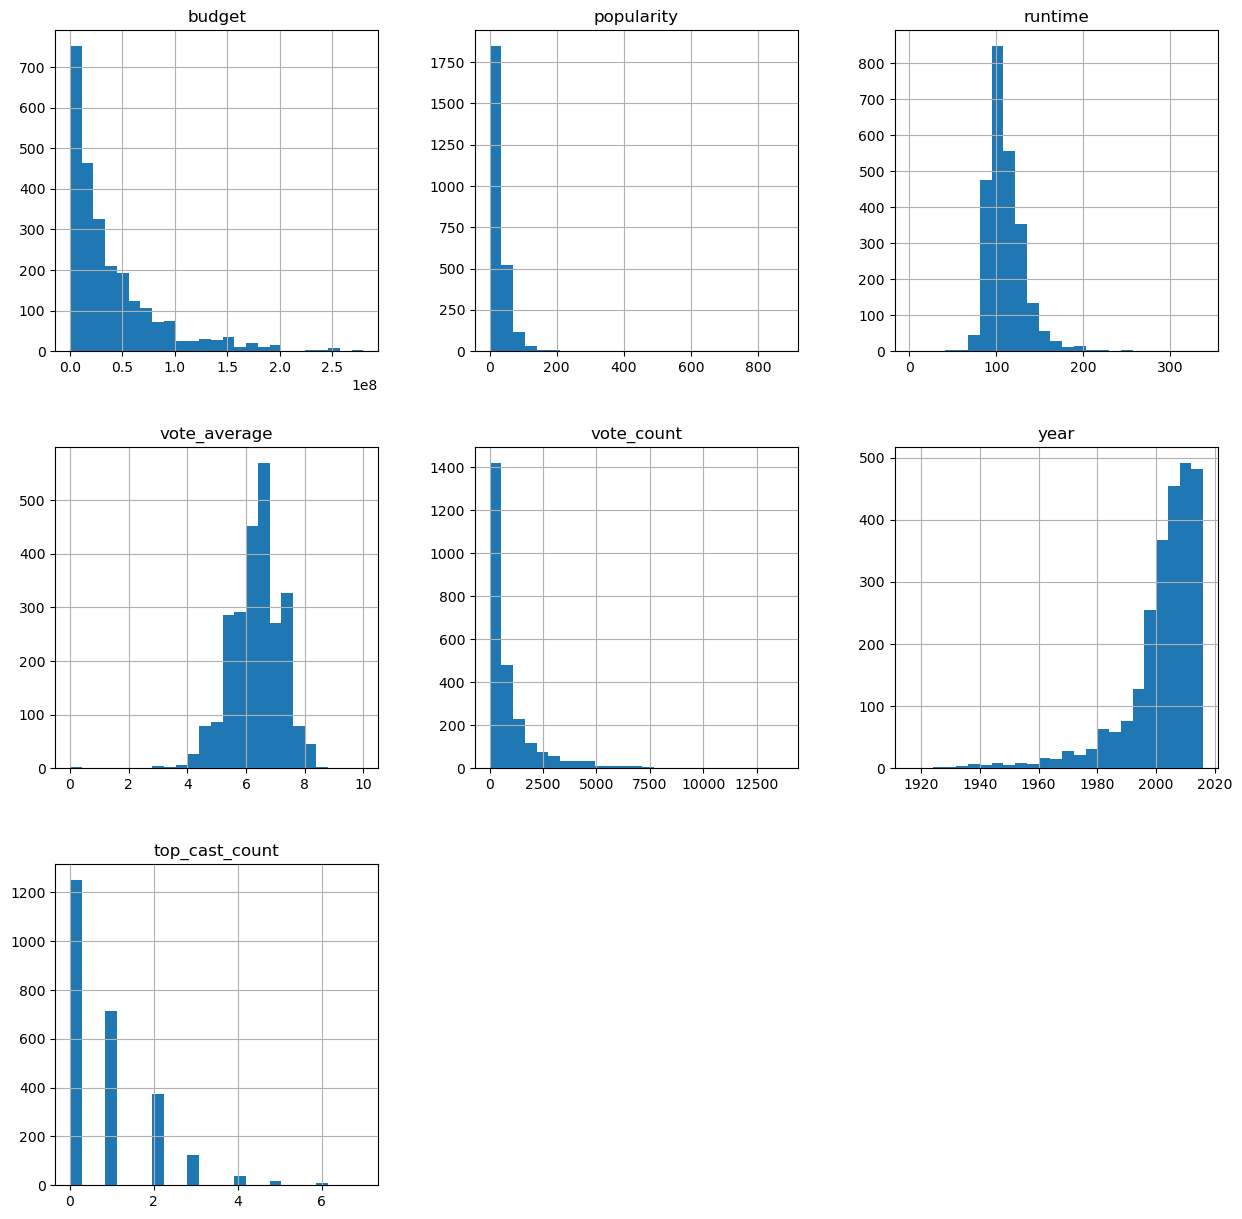

In [40]:
numeric = pd.concat([exploratory.select_dtypes(['int64', 'float64']), notional_to_numeric], axis=1)
numeric.hist(figsize=(15,15), bins=25)

In [41]:
numeric

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
2632,25000000,8.583217,92.0,6.1,182,1999,0
1332,40000000,27.009723,110.0,5.8,594,2012,2
3756,4000000,29.852608,94.0,7.1,550,1988,0
2804,12500000,34.821223,94.0,7.7,1451,2008,0
3037,10000000,2.959547,99.0,6.6,50,1980,1
...,...,...,...,...,...,...,...
3038,25000000,4.068107,110.0,6.0,57,1999,2
1040,45000000,26.721386,86.0,6.4,1424,1997,0
80,170000000,77.178973,127.0,5.8,3118,2012,0
2058,21000000,13.906611,145.0,7.2,277,2006,0


In [42]:
numeric.corr().style.background_gradient(cmap='RdYlGn')

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
budget,1.000000,0.430113,0.224054,-0.027924,0.562590,0.257234,0.328946
popularity,0.430113,1.000000,0.169547,0.273069,0.734870,0.143048,0.192979
runtime,0.224054,0.169547,1.000000,0.358257,0.247845,-0.170340,0.153013
vote_average,-0.027924,0.273069,0.358257,1.000000,0.360786,-0.206507,0.071554
vote_count,0.562590,0.734870,0.247845,0.360786,1.000000,0.163001,0.241500
year,0.257234,0.143048,-0.170340,-0.206507,0.163001,1.000000,0.164702
top_cast_count,0.328946,0.192979,0.153013,0.071554,0.241500,0.164702,1.000000


<Axes: xlabel='popularity', ylabel='vote_count'>

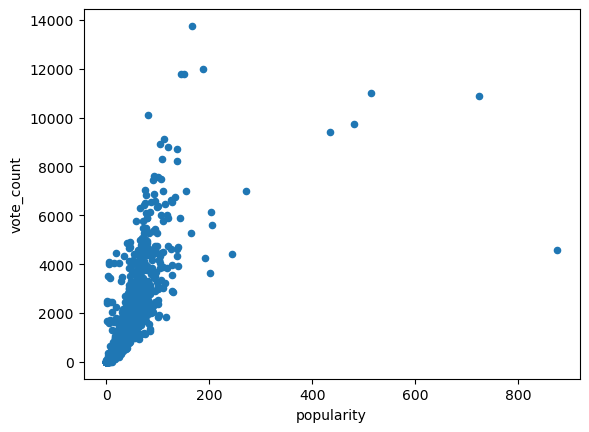

In [43]:
numeric.plot(kind='scatter', x='popularity', y='vote_count') # strongly correlated features

We had to take care of **heteroscedasticity**. Luckily log transformation took care of it. Now we have more or less the same variance of residuals across all values.
We also could notice some outliers. Let's take a look at observations with popularity higher than 400.

<Axes: xlabel='popularity', ylabel='vote_count'>

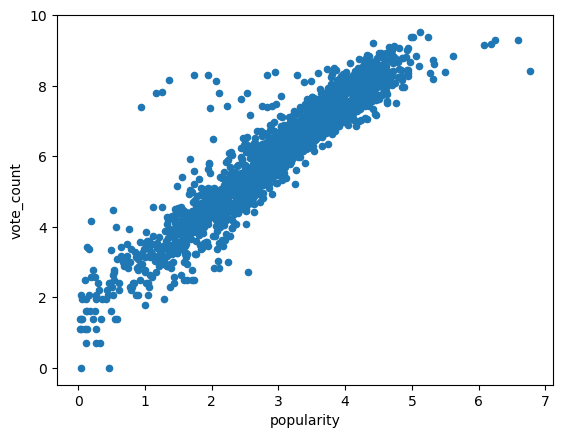

In [44]:
possible_outliers = exploratory[exploratory['popularity'] > 400]

numeric[['popularity', 'vote_count']] = np.log(exploratory[['popularity', 'vote_count']] + 1)
numeric.plot(kind='scatter', x='popularity', y='vote_count')

In [45]:
possible_outliers # huge blockbusters -> nothing to worry about then

,budget,genres,homepage,keywords,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,cast,crew
94,170000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",http://marvel.com/guardians,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,481.098624,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2014-07-30,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.9,9742,"[{""cast_id"": 1, ""character"": ""Peter Quill / St...","[{""credit_id"": ""538ce329c3a3687155003358"", ""de..."
546,74000000,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",http://www.minionsmovie.com/,"[{""id"": 3487, ""name"": ""assistant""}, {""id"": 179...",en,875.581305,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-17,91.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,6.4,4571,"[{""cast_id"": 22, ""character"": ""Scarlet Overkil...","[{""credit_id"": ""5431b2b10e0a2656e20026c7"", ""de..."
95,165000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",http://www.interstellarmovie.net/,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,724.247784,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2014-11-05,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,8.1,10867,"[{""cast_id"": 9, ""character"": ""Joseph Cooper"", ...","[{""credit_id"": ""52fe4bbf9251416c910e4801"", ""de..."
788,58000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.foxmovies.com/movies/deadpool,"[{""id"": 2095, ""name"": ""anti hero""}, {""id"": 307...",en,514.569956,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-02-09,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.4,10995,"[{""cast_id"": 99, ""character"": ""Wade Wilson / D...","[{""credit_id"": ""56c986b2925141172f0068b6"", ""de..."
127,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.madmaxmovie.com/,"[{""id"": 2964, ""name"": ""future""}, {""id"": 3713, ...",en,434.278564,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-05-13,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.2,9427,"[{""cast_id"": 2, ""character"": ""Max Rockatansky""...","[{""credit_id"": ""577da370c3a36817f8003838"", ""de..."


In [46]:
numeric.corr().style.background_gradient(cmap='coolwarm')

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
budget,1.000000,0.491464,0.224054,-0.027924,0.508908,0.257234,0.328946
popularity,0.491464,1.000000,0.185647,0.340449,0.937469,0.197206,0.299799
runtime,0.224054,0.185647,1.000000,0.358257,0.191057,-0.170340,0.153013
vote_average,-0.027924,0.340449,0.358257,1.000000,0.368011,-0.206507,0.071554
vote_count,0.508908,0.937469,0.191057,0.368011,1.000000,0.210994,0.312848
year,0.257234,0.197206,-0.170340,-0.206507,0.210994,1.000000,0.164702
top_cast_count,0.328946,0.299799,0.153013,0.071554,0.312848,0.164702,1.000000


In [47]:
feature_mean = make_pipeline(FeatureSelector(['vote_count', 'popularity']), MeanTransformer('popularity_vote')).fit_transform(exploratory)
feature_mean.head()

,popularity_vote
2632,95.291608
1332,310.504862
3756,289.926304
2804,742.910611
3037,26.479774


In [48]:
numeric['vote_popularity'] = feature_mean
numeric.drop(columns=['popularity', 'vote_count'], inplace=True)

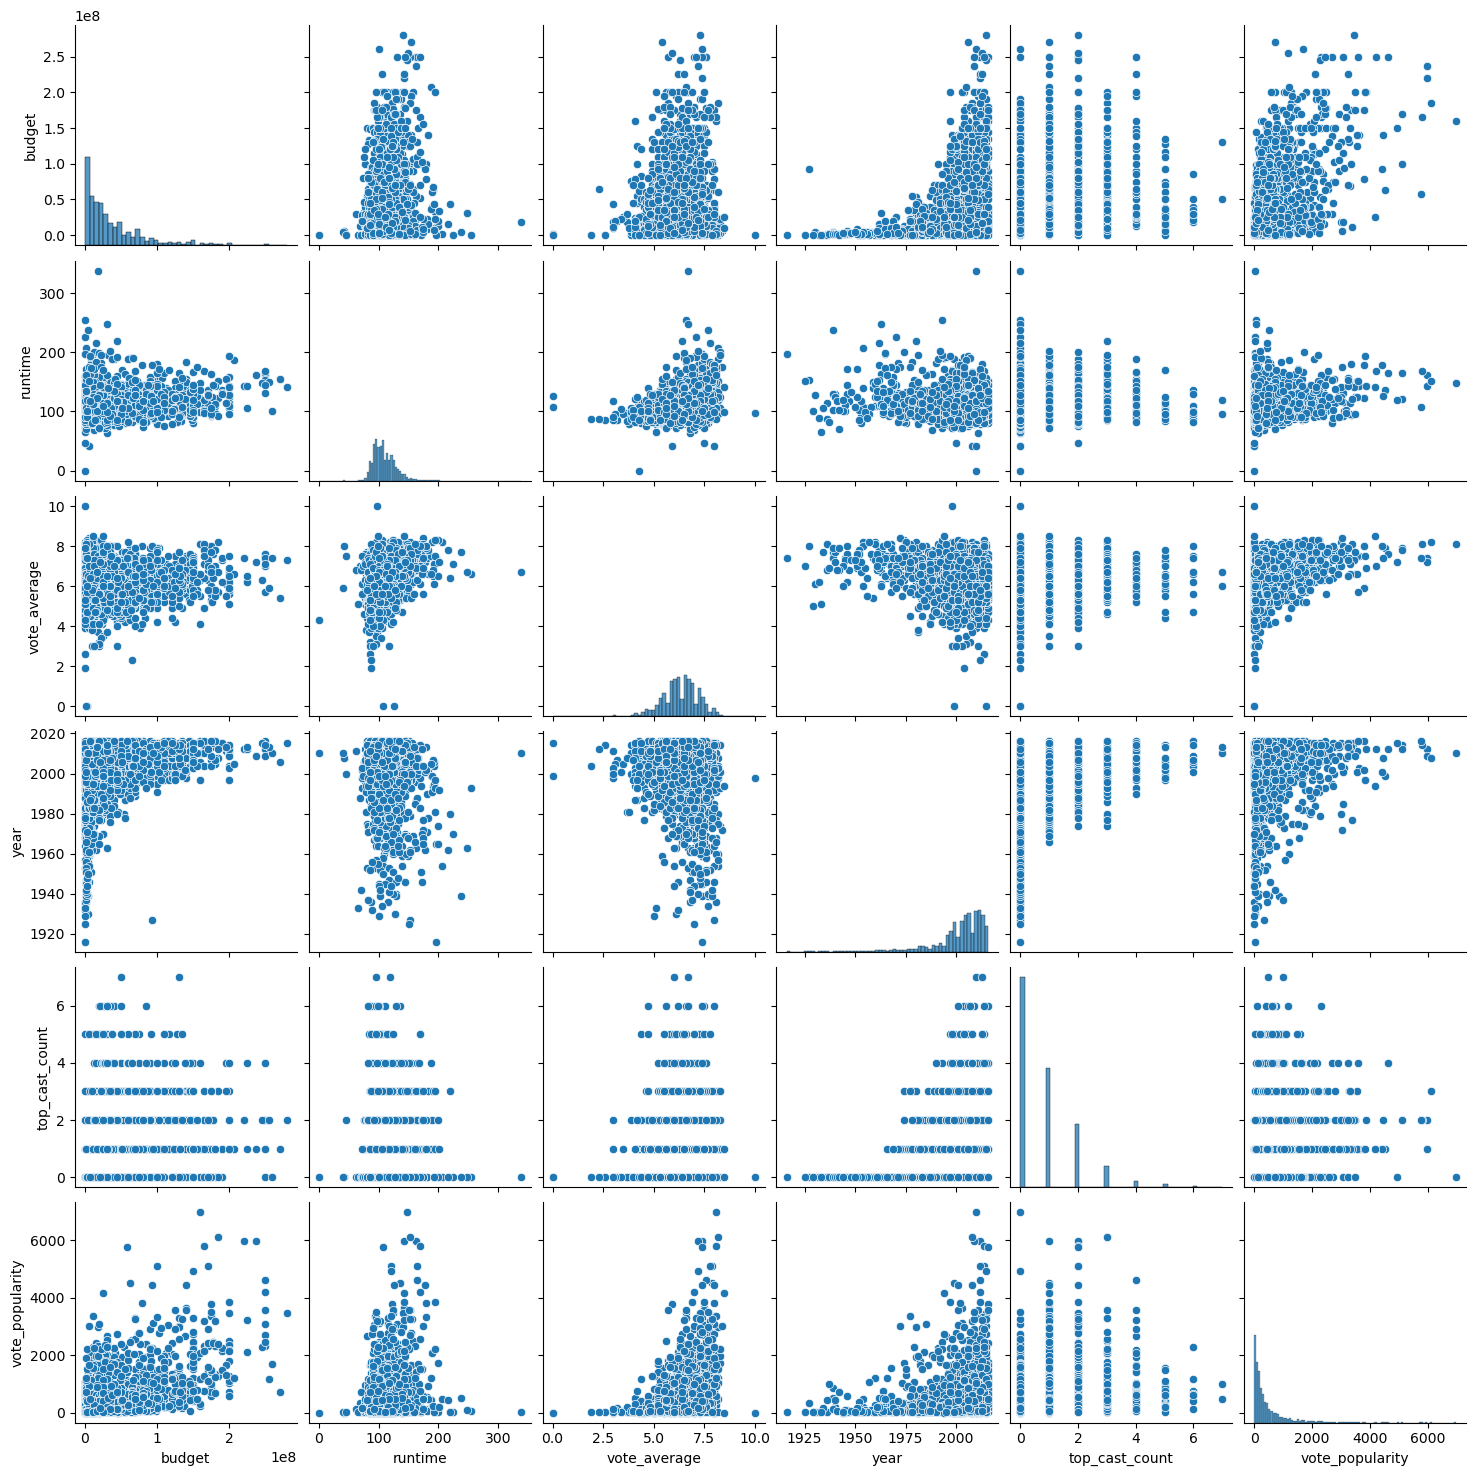

In [49]:
sns.pairplot(numeric)

R2 score - wsp. determinancji:
Informuje o tym, jaka część zmienności (wariancji) zmiennej objaśnianej w próbie pokrywa się z korelacjami ze zmiennymi zawartymi w modelu. Jest on więc miarą stopnia, w jakim model pasuje do próby. Współczynnik determinacji przyjmuje wartości z przedziału jeśli w modelu występuje wyraz wolny, a do estymacji parametrów wykorzystano metodę najmniejszych kwadratów. Jego wartości najczęściej są wyrażane w procentach. Dopasowanie modelu jest tym lepsze, im wartość R² jest bliższa jedności. Wyraża się on wzorem: 
$$R^{2}:={\frac {\sum \limits _{i=1}^{n}({\hat {y}}_{i}-{\overline {y}})^{2}}{\sum \limits _{i=1}^{n}(y_{i}-{\overline {y}})^{2}}}$$

Na logikę - wariancja estymat podzielona przez rzeczywistą wariancję. Model lepiej dopasowuje sie do danych niż średnia - obliczanie tej różnicy:  $R^2$.  <br>
$R^2 = \frac{Var(mean)-Var(model)}{Var(mean)}$ --- jest 81% mniej wariancji między wyjściem modelu (np linią) niż między średnią

Poprawna definicja - mierzy proporcje wariancji zmiennej zależnej wyjaśnianej przez zmienne niezależne w modelu regresji.

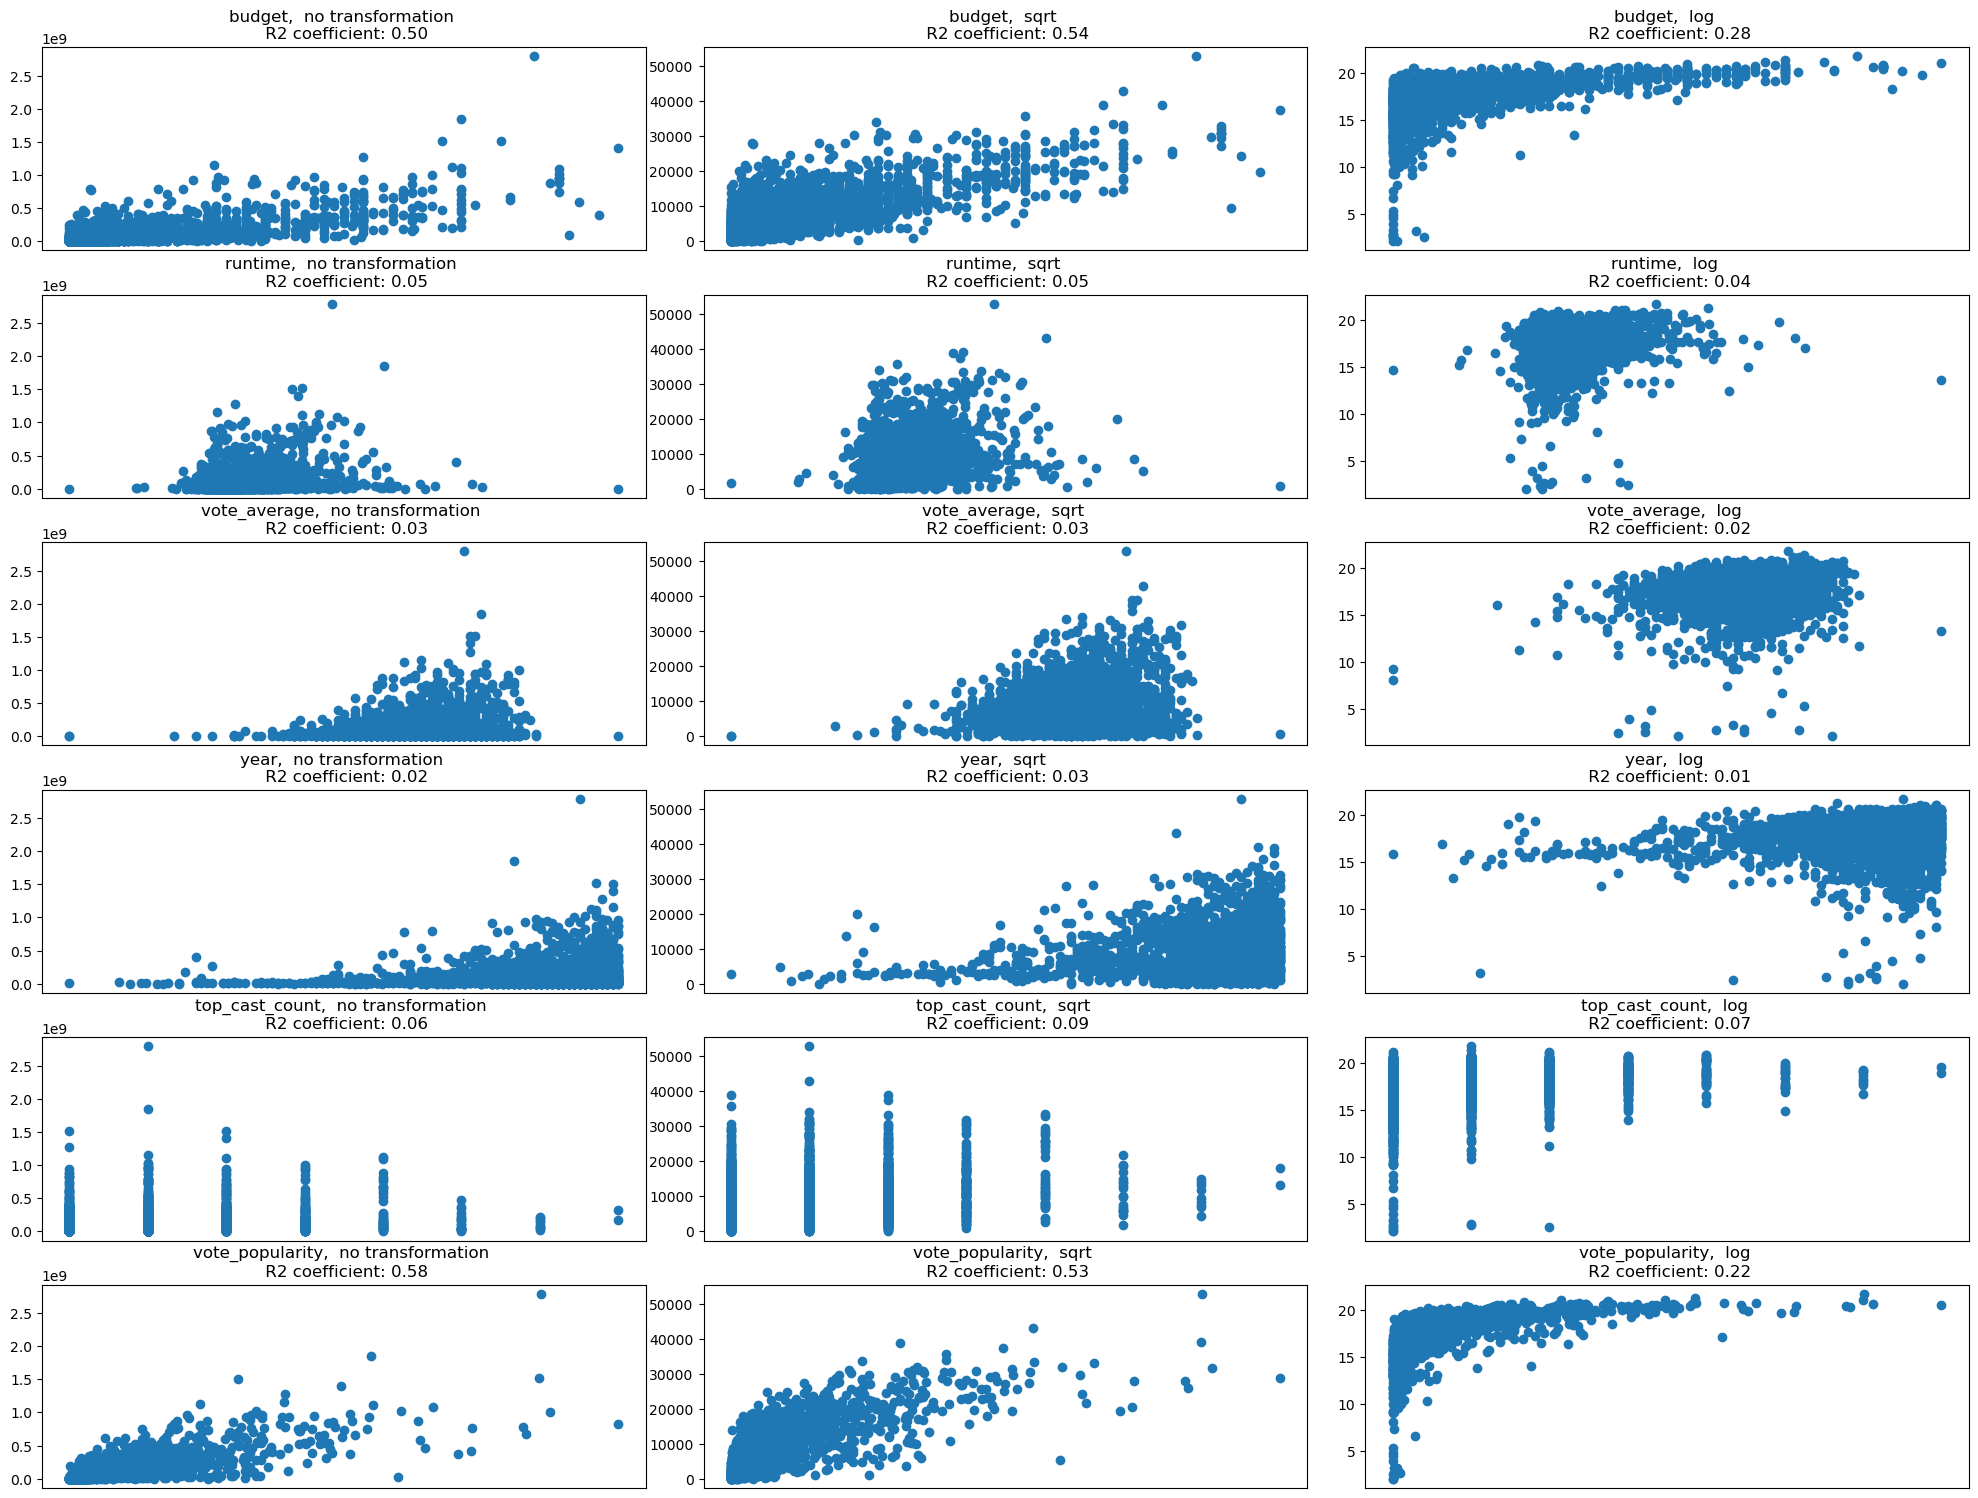

In [50]:
from scipy.stats import pearsonr

transformations = [lambda x: x, np.sqrt, lambda x: np.log(x+1)]
tran_description = [' no transformation', ' sqrt', ' log']
numeric_columns = numeric.columns

fig, axes = plt.subplots(len(numeric_columns), len(transformations), figsize=(20,15))
fig.tight_layout()

for col_idx, col in enumerate(numeric_columns):
    for tran_idx, tran in enumerate(transformations):
        axes[col_idx, tran_idx].scatter(x=numeric[col], y=tran(y_train))
        axes[col_idx, tran_idx].set_xticklabels([])
        axes[col_idx, tran_idx].set_xticks([]) 
        R2 = pearsonr(numeric[col], tran(y_train))[0]**2     
        axes[col_idx, tran_idx].title.set_text(f'{col}, {tran_description[tran_idx]} \n R2 coefficient: {R2:.2f}')
               
plt.show()

# 2. Building a pipeline

In [51]:
union = make_union(
    make_pipeline(
        FeatureSelector('genres'),
        DictionaryVectorizer('name')
    ),
    make_pipeline(
        FeatureSelector('homepage'),
        Binarizer(lambda x: isinstance(x, float), 'missing_homepage')
    ),
    make_pipeline(
        FeatureSelector('keywords'),
        DictionaryVectorizer('name'),
        TopFeatures(0.5)
    ),
    make_pipeline(
        FeatureSelector('original_language'),
        Binarizer(lambda x: x == 'en', 'en')
    ),
    make_pipeline(
        FeatureSelector('production_companies'),
        DictionaryVectorizer('name'),
        TopFeatures(1)
    ),
    make_pipeline(
        FeatureSelector('production_countries'),
        DictionaryVectorizer('name'),
        TopFeatures(25)
    ),
    make_pipeline(
        FeatureSelector('release_date'),
        DateTransformer()
    ),
    make_pipeline(
        FeatureSelector('spoken_languages'),
        ItemCounter(),
        Binarizer(lambda x: x > 1, 'multilingual')
    ),
    make_pipeline(
        FeatureSelector('original_language'),
        Binarizer(lambda x: x == 'Released', 'Released')
    ),    
    make_pipeline(
        FeatureSelector('cast'),
        DictionaryVectorizer('name'),
        TopFeatures(0.25),
        SumTransformer('top_cast_count')
    ),
    make_pipeline(
        FeatureSelector('crew'),
        DictionaryVectorizer('name', False),
        TopFeatures(1)
    ),
    make_pipeline(
        FeatureSelector(['budget', 'runtime', 'vote_average'])
    ),
    make_pipeline(
        FeatureSelector(['popularity', 'vote_count']),
        MeanTransformer('popularity_vote')
    )
)

In [52]:
# using it without union: pd.concat((df, pipe.fit_transform(df)) ,axis=1) ...

In [53]:
%%time
union.fit(X_train)
print('Fitted')

Fitted
CPU times: user 6.29 s, sys: 93.3 ms, total: 6.39 s
Wall time: 6.39 s


In [54]:
%%time
X_train_T = union.transform(X_train)
X_test_T = union.transform(X_test)

print(X_train_T.shape)
print(X_test_T.shape)

(2534, 144)
(845, 144)
CPU times: user 3.75 s, sys: 127 ms, total: 3.87 s
Wall time: 3.88 s


In [55]:
# little post processing
X_train_T = handle_same_name_col(X_train_T)
X_test_T = handle_same_name_col(X_test_T)

Duplicate found
Duplicate found


In [56]:
X_train_T.columns.duplicated().sum()

0

In [57]:
# sns.histplot(X_test_T.budget, kde=True)

In [ ]:
# TODO: based on features distribution scale it with proper scalers

In [58]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
scaler = Scaler(columns=['budget'], scaler=StandardScaler())
X_train_S = scaler.fit_transform(X_train_T)
X_test_S = scaler.transform(X_test_T)

In [59]:
# sns.histplot(X_test_S.budget, kde=True)

# 3. Building regressor

In [60]:
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 0
#     }

In [82]:
np.linspace(0.01, 0.1, 10)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [83]:
%%time
from predictors import stacking_regressor_pipe

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


params = {
    'n_estimators': np.linspace(100, 1000, 10).astype(int),
    # 'max_depth': np.arange(3,8)
    'learning_rate': np.linspace(0.01, 0.1, 10)
}

regressors = [XGBRegressor(verbosity=0), LGBMRegressor(verbose=-1), CatBoostRegressor(verbose=0)]
param_list = [params, params, params]

ensemble, weak_learners = stacking_regressor_pipe(X=X_train_T,
                                   y=y_train,
                                   regressors=regressors,
                                   params=param_list,
                                   final_estimator=MLPRegressor())

y_hat = ensemble.predict(X_test_T)

CPU times: user 59min 36s, sys: 1min 49s, total: 1h 1min 26s
Wall time: 5min 38s


In [62]:
ensemble_mae = mean_absolute_error(y_hat, y_test)
ensemble_r2 = r2_score(y_hat, y_test)
ensemble_r2, ensemble_mae

(0.7164131197388182, 47136637.68366897)

In [84]:
ensemble_mae = mean_absolute_error(y_hat, y_test)
ensemble_r2 = r2_score(y_hat, y_test)
ensemble_r2, ensemble_mae

(0.7493620844507618, 46235385.97408483)

In [ ]:
# for the same split better hpo resulted in
# (0.7164131197388182, 47136637.68366897) -> (0.7493620844507618, 46235385.97408483)

In [85]:
# sanity check
ensemble_mae = mean_absolute_error(y_hat, y_test)
for i, model in enumerate(weak_learners):
    y_hat_weak = model[1].predict(X_test_T)
    mae = mean_absolute_error(y_hat_weak, y_test)
    if mae < ensemble_mae:
        print(f'Weak learner {i} is better than ensemble')

Weak learner 1 is better than ensemble


In [86]:
y_hat1 = weak_learners[1][1].predict(X_test_T)
r2_score(y_hat1, y_test), mean_absolute_error(y_hat1, y_test)

(0.7330102240146733, 45975472.81337232)

In [64]:
feature_importances = [model[1].feature_importances_ for model in weak_learners]
feature_importances = pd.DataFrame(feature_importances, columns=X_train_T.columns)
feature_importances

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science_fiction,thriller,war,western,missing_homepage,duringcreditsstinger,woman_director,based_on_novel,independent_film,aftercreditsstinger,murder,dystopia,violence,sequel,sport,revenge,friendship,3d,biography,teenager,musical,alien,love,sex,los_angeles,suspense,superhero,police,london_england,new_york,world_war_ii,magic,prison,high_school,drug,nudity,dying_and_death,daughter,father_son_relationship,based_on_comic_book,family_55,hospital,en,warner_bros_,universal_pictures,paramount_pictures,twentieth_century_fox_film_corporation,columbia_pictures,new_line_cinema,metro_goldwyn_mayer__mgm_,walt_disney_pictures,touchstone_pictures,relativity_media,columbia_pictures_corporation,village_roadshow_pictures,united_artists,miramax_films,dreamworks_skg,regency_enterprises,dune_entertainment,lionsgate,fox_searchlight_pictures,working_title_films,fox_2000_pictures,dimension_films,summit_entertainment,canal_,tristar_pictures,amblin_entertainment,the_weinstein_company,studiocanal,dreamworks_animation,original_film,united_states_of_america,united_kingdom,germany,france,canada,australia,spain,italy,china,japan,hong_kong,india,ireland,new_zealand,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed,month_sin,month_cos,day_sin,day_cos,multilingual,Released,top_cast_count,robert_rodriguez,mary_vernieu,steven_spielberg,hans_zimmer,james_newton_howard,deborah_aquila,harvey_weinstein,bob_weinstein,avy_kaufman,francine_maisler,bruce_berman,budget,runtime,vote_average,popularity_vote
0,0.001420,0.014447,0.014799,0.003251,0.005230,0.00022,0.008628,0.031832,0.007257,0.0,0.000588,0.000342,0.002304,0.007501,0.008065,0.005429,0.006516,0.001077,0.002736,0.010954,0.002625,0.003523,0.003977,0.001544,0.011603,0.001888,0.011563,0.000144,0.003749,0.0,0.000708,0.003751,0.013871,0.025695,0.000013,0.007656,0.006799,0.000616,0.0,0.001413,0.005940,0.002065,0.0,0.00752,0.002346,0.017546,0.008737,0.001736,0.001191,0.0,0.003704,0.003607,0.003473,0.0,0.002135,0.001996,0.0,0.00098,0.013542,0.006125,0.005213,0.031359,0.003766,0.00117,0.000158,0.001617,0.000806,0.025332,0.000455,0.03032,0.0,0.001632,0.002891,0.002269,0.023193,0.002132,0.001529,0.00101,0.000000,0.0,0.030594,0.003265,0.001477,0.001559,0.0,0.0,0.000000,0.015577,0.00112,0.002698,0.006404,0.002269,0.00283,0.001493,0.0,0.0,0.00307,0.009484,0.002438,0.002463,0.002749,0.001838,0.009431,0.003111,0.003463,0.005653,0.002631,0.003627,0.000212,0.016045,0.001364,0.028847,0.003323,0.002156,0.006848,0.003212,0.000925,0.001612,0.0,0.003559,0.006057,0.006787,0.006017,0.013433,0.004045,0.005704,0.021496,0.0,0.004252,0.000000,0.001300,0.008342,0.012635,0.002830,0.002745,0.003041,0.000000,0.000000,0.002047,0.000000,0.079599,0.013719,0.011734,0.155641
1,9.000000,7.000000,14.000000,13.000000,8.000000,0.00000,5.000000,28.000000,2.000000,0.0,0.000000,1.000000,1.000000,2.000000,22.000000,21.000000,10.000000,0.000000,0.000000,8.000000,4.000000,2.000000,0.000000,2.000000,0.000000,0.000000,10.000000,0.000000,5.000000,0.0,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,0.0,0.000000,0.000000,0.0,0.00000,1.000000,6.000000,7.000000,8.000000,0.000000,1.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,5.000000,0.000000,3.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,114.000000,0.000000,0.000000,9.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000,2.000000,0.000000,6.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,32.000000,21.000000,24.000000,13.000000,5.000000,0.0,3.000000,0.000000,0.000000,6.000000,2.000000,7.000000,0.000000,0.0000

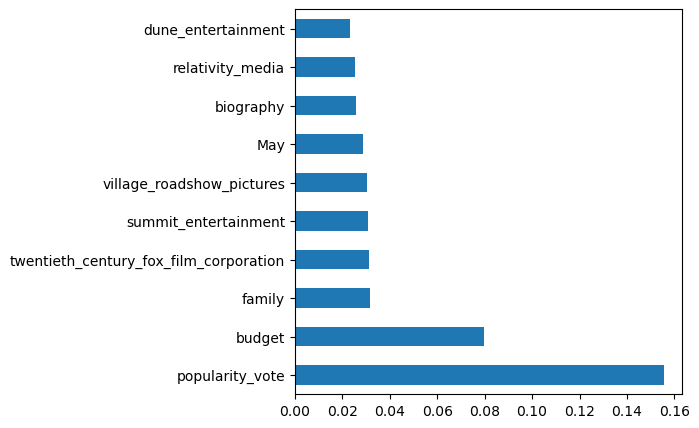

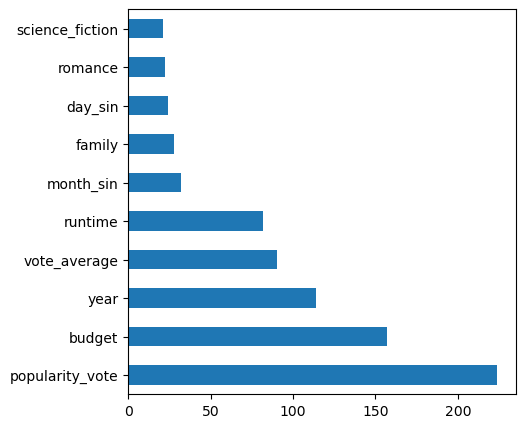

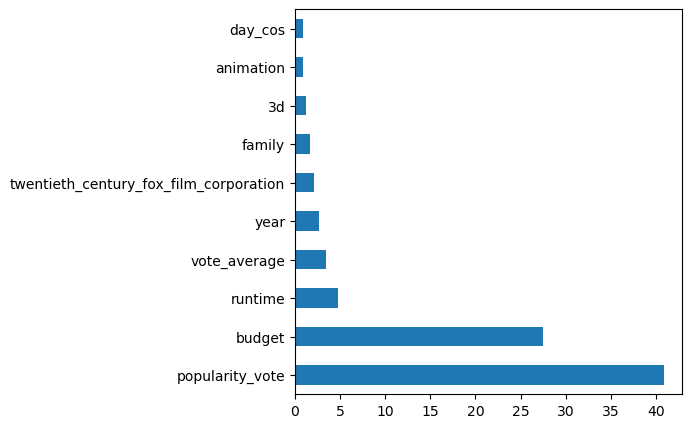

In [87]:
plot_weak_learners_feature_importance(feature_importances)

### Retrain for best features experiment
Interesting approach but that might lead to overfitting

In [ ]:
X_train_best_disj, X_test_best_disj = data_with_important_features(X_train_T, X_test_T, feature_importances, conjunction=False)
ensemble, weak_learners = stacking_regressor_pipe(X_train_best_disj,
                                   y_train,
                                   regressors,
                                   param_list,
                                   MLPRegressor())

y_hat_disj = ensemble.predict(X_test_best_disj)
r2_score(y_hat_disj, y_test), mean_absolute_error(y_hat_disj, y_test)

In [ ]:
X_train_best_conj, X_test_best_conj = data_with_important_features(X_train_T, X_test_T, feature_importances, conjunction=True)
ensemble, weak_learners = stacking_regressor_pipe(X_train_best_conj,
                                   y_train,
                                   regressors,
                                   param_list,
                                   MLPRegressor())
y_hat_conj = ensemble.predict(X_test_best_conj)
r2_score(y_hat_conj, y_test), mean_absolute_error(y_hat_conj, y_test)

In [ ]:
# check for those if weak learner is not better than stacked regressor xd

In [ ]:
# disjunction looks much better (for now at least)

In [ ]:
# more compact stack regressor
# better hpo for gradient boosting trees
# feature selection transformer - based on dtype - stat test, correlation, variance thshr
# prepare code classifiers - using metrics, g-mean, f1, roc aur
# eda classification problems

In [ ]:
# import matplotlib.pyplot as plt
# N = 30
# x = np.arange(y_hat.shape[0])[:N]
# plt.figure(figsize=(10,10))
# plt.plot(x, y_hat[:N], label='prediction')
# plt.plot(x, y_test[:N], label='truth')
# plt.xticks(visible=False)
# plt.legend()
# plt.show()